# Ising model - metropolis algorithm

Mathematics based on
* page 1 and 2 of https://phas.ubc.ca/~rozali/8.pdf
* https://www.math.pku.edu.cn/teachers/litj/notes/appl_stoch/lect7.pdf
* https://www.asc.ohio-state.edu/braaten.1/statphys/Ising_MatLab.pdf

All websites accessed on 07/24/24.

## 1. Ising model

We consider a spin chain of $N$ electrons with periodic boundary conditions and nearest neighbour interactions. It's Hamiltonian is given by
$$ H = -J \sum_{i=1}^N s_i s_{i+1} - h \sum_{i=1}^N s_i, $$
where $J$ is the coupling constant, $h$ is the external field, and $s_i$ is the spin of the $i$-th electron. All $s_i$ must take the value of either $-1$ or $+1$. The first term describes the spin interactions, and the second describes the interaction of the spin with the external field $h$.

One often consideres the total spin
$$ M = \sum_{i=1}^{N} s_i, $$
i.e., the total number of up spins in the chain, often associated with magnetisation in the context of magnetic field interactions.

<div>
<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1140%2Fepjb%2Fs10051-022-00304-1/MediaObjects/10051_2022_304_Fig1_HTML.png?as=webp" width="600"/>
</div>
Figure from: Ramkarthik, M. S., & Mandal, A. (2022). On certain classes of exact solutions of two magnon states in the Heisenberg spin chain. The European Physical Journal B, 95(3), 45.

## 2. Metropolis algorithm

Following page 2 of https://phas.ubc.ca/~rozali/8.pdf
<blockquote>
The Metropolis algorithm isa widely used Monte Carlo simulation that dynamically guides a given spin configuration towards thermal equilibrium. The steps needed to write the algorithm can be briefly outlined as follows:


1.   Generate a random spin configuration $(\sigma_1, \sigma_2, ...,\sigma_N)$ with energy $E_0$;
2.   Flip a random spin $\sigma_k→-\sigma_k$ and calculate energy of this trial state;
3.  Calculate the difference in energy generated by the spin flip, $ΔE=E_t - E_0$, and the associated transition probability $p=e^{-\beta ΔE}$, where $β = 1/(k_BT)$ is the inverse temperature.
  *   If $ΔE\leq 0$, then we accept the spin flip because the trial spin configuration is energetically favoured over the initial state;
  *   If $ΔE> 0$, then we compare the transition probability $p$ to a random number $r$ drawn from uniform distribution in range $[0,1]$. We accept the new configuration if $r\leq p$.Otherwise,we keep the spin unflipped.
4. Update the average energy, magnetization, etc.
5. Repeat steps (2) to (4) with the chosen spin configuration until thermal equilibrium has been reached.
</blockquote>

## 3. Implementation

We implement the algorithm above in the class `IsingModel` below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [42]:
class IsingModel:
  def __init__(self,
               n_particles: int,
               coupling_constant: float,
               external_field: float,
               beta: float):
    """
    Initializes the class. Parameters:
    * n_particles: int
      Total number of spins in the chain
    * coupling_constant: float
      Coupling constant between neighboring spins
    * external_field: float
      Magnitude of the external magnetic field
    * beta: float
      Inverse temperature
    """
    # Assert the temperature is >= 0
    assert beta >= 0, "beta must be >=0"

    self.n_particles = n_particles
    self.j = coupling_constant
    self.h = external_field
    self.beta = beta

    # Initialize the spin configuration
    # Equivalent to step 1. of the Metropolis algorithm description above
    self.spin_chain = 2 * np.random.randint(2, size=n_particles) - 1

    # Initialize the list that stores the total energy
    self.energies = [self.get_total_energy()]

    # Initialize the list that stores the magnetization
    self.magnetizations = [self.get_magnetization()]

  def get_interaction_energy(self, chain: np.ndarray = None) -> float:
    """
    Calucates the interaction energy of the spin chain.
    First term in the hamiltonian in description.

    Parameters:
    * chain: np.ndarray
      The spin chain to evaluate the energy of. If not given, self.spin_chain is used.
    """
    if chain is None:
      chain = self.spin_chain
                           # Neighbors                                 + element due to periodic boundary conditions
    return self.j * np.sum(chain[:-1] * chain[1:]) + self.j * chain[0] * chain[-1]

  def get_field_energy(self, chain: np.ndarray = None) -> float:
    """
    Calculates the field energy of the spin chain.
    Second term in the hamiltonian in description.

    Parameters:
    * chain: np.ndarray
      The spin chain to evaluate the energy of. If not given, self.spin_chain is used.
    """
    if chain is None:
      chain = self.spin_chain

    return self.h * np.sum(chain)

  def get_total_energy(self, chain: np.ndarray = None) -> float:
    """
    Calculates the total energy of the spin chain.

    Parameters:
    * chain: np.ndarray
      The spin chain to evaluate the energy of. If not given, self.spin_chain is used.
    """
    if chain is None:
      return self.get_interaction_energy() + self.get_field_energy()

    return self.get_interaction_energy(chain) + self.get_field_energy(chain)

  def get_magnetization(self) -> float:
    """
    Calculates the magnetization of the spin chain.
    """
    return np.sum(self.spin_chain)

  def show_chain(self, grid: bool = False) -> None:
    """
    Plots the spin chain

    Parameters:
    * grid: bool
      If True, the grid is shown
    """
    plt.figure( figsize = (10,1))
    plt.imshow(np.expand_dims( self.spin_chain + 0.5, axis=0), cmap = "bwr")
    if grid:
      for i in range(self.n_particles - 1):
        plt.axvline(i + 0.5, color="white")
    plt.axis("off")
    plt.title(f"Chain after {len(self.energies)-1} steps")
    plt.show()

  def conditioned_spin_flip(self):
    """
    Performs a spin flip with the Metropolis algorithm.
    Equivalent to steps 3 & 4 of the algorithm above.
    """
    # Randomly choose a spin
    i = np.random.randint(0, self.n_particles)

    # Compute new chain
    new_chain = np.copy(self.spin_chain)
    new_chain[i] *= -1

    # Compute the change in energy
    delta_E = self.get_total_energy(new_chain) - self.get_total_energy()

    # Check whether to accept the new chain
    if delta_E <= 0:
      # Accept new chain
      self.spin_chain = new_chain
    else:
      ### Conditionally accept the new chain
      # Compute probability of transition
      prob = np.exp(-delta_E * self.beta)
      if np.random.rand() < prob:
        # Accept new chain
        self.spin_chain = new_chain

    # Update the list that stores the total energy
    self.energies.append(self.get_total_energy())

    # Update the list that stores the magnetization
    self.magnetizations.append(self.get_magnetization())

  def run_algorithm(self,
                    n_steps: int,
                    show_chain_interval: int = 100) -> None:
    """
    Runs the Metropolis algorithm for a given number of steps.

    Parameters:
    * n_steps: int
      Number of steps to run the algorithm
    * show_chain_interval: int
      Interval at which to show the spin chain
    """
    for n in range(n_steps):
      self.conditioned_spin_flip()
      if (n+1) % show_chain_interval == 0:
        self.show_chain()

  def plot_energy_and_magnetization(self) -> None:
    """
    Plots the total energy and magnetization
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    axs[0].plot(self.energies)
    axs[0].set_title("Energy")
    axs[0].set_xlabel("Step")
    axs[1].plot(self.magnetizations)
    axs[1].set_title("Magnetization")
    axs[1].set_xlabel("Step")
    plt.show()

## 4. Results.

We cnside

We will the following cases:

*   (a) no external field $h=0$, no interactions $J=0$.
*   (b) external field $h=1$, no interactions $J=0$, low temperature $\beta\gg1$.
*   (c) external field $h=1$, no interactions $J=0$, high temperature $\beta\ll1$.
*   (d) no external field $h=1$, interactions $J=1$, low temperature $\beta\gg1$.
*   (e) no external field $h=1$, interactions $J=1$, high temperature $\beta\gg1$.



### 4a. No external field, no interactions.

$$h = 0, J = 0.$$

The energy in time is $0$, since the Hamiltonian is $0$. The spins should end up looking randomly.

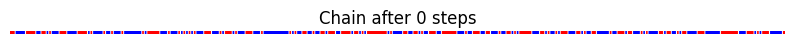

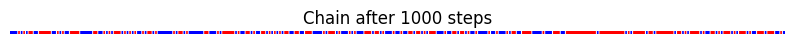

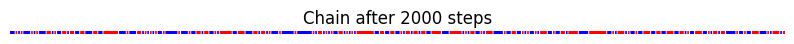

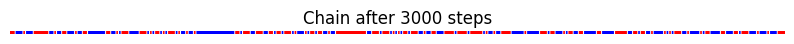

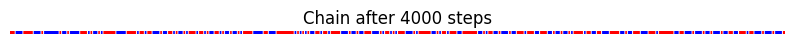

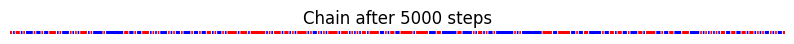

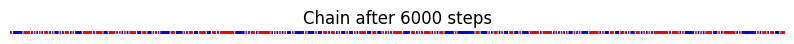

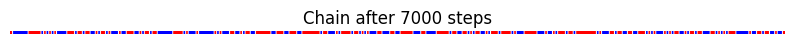

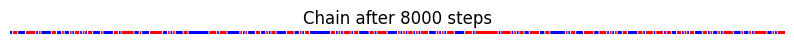

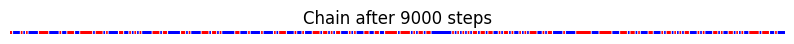

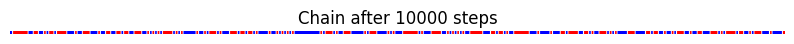

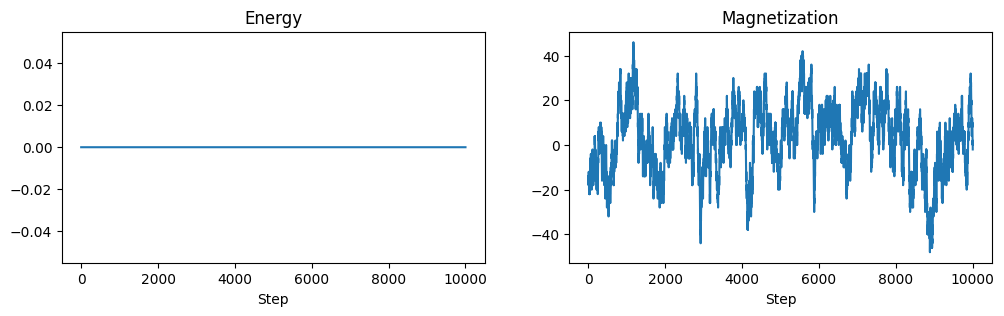

In [43]:
model_a = IsingModel(
  n_particles = 300,
  coupling_constant = 0,
  external_field = 0,
  beta = 100000
)
model_a.show_chain()
model_a.run_algorithm(10000, 1000)
model_a.plot_energy_and_magnetization()


### 4b. External field, no interactions, low temperature

$$h = 1, J = 0, \beta = 100000.$$

The spins should end up being oriented in the same direction.

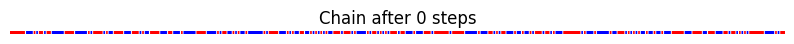

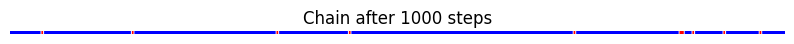

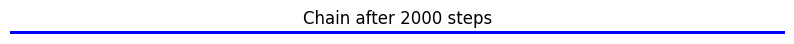

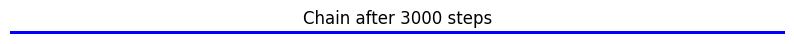

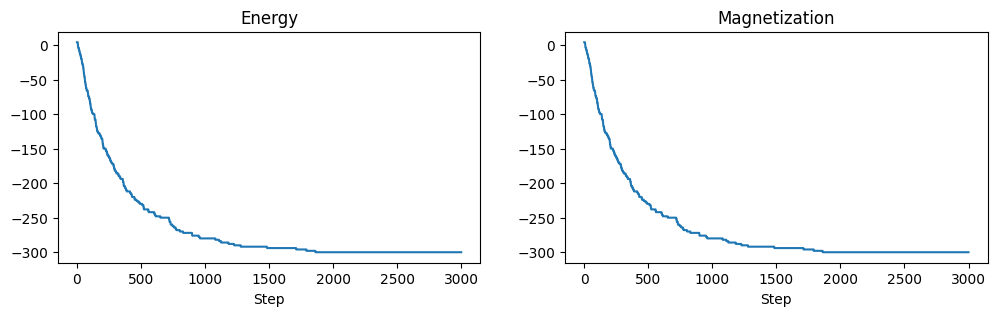

In [44]:
NUM_STEPS = 3000

model_b = IsingModel(
  n_particles = 300,
  coupling_constant = 0,
  external_field = 1,
  beta = 100000
)
model_b.show_chain()
model_b.run_algorithm(NUM_STEPS, 1000)
model_b.plot_energy_and_magnetization()

### 4c. External field, no interactions, low temperature

$$h = 1, J = 0, \beta = 0.25.$$

The spins should look a bit more randomly.

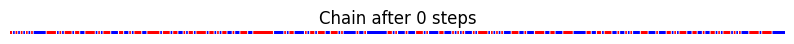

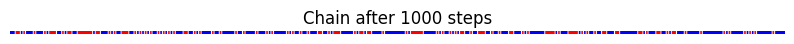

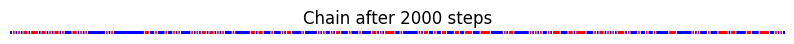

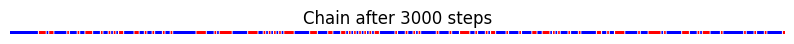

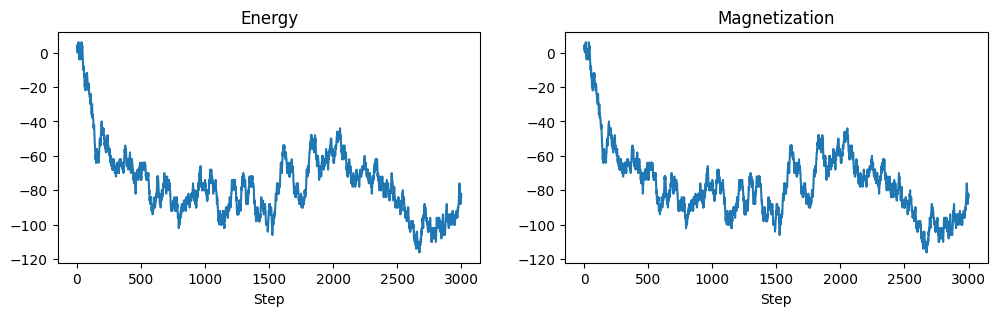

In [45]:
NUM_STEPS = 3000

model_c = IsingModel(
  n_particles = 300,
  coupling_constant = 0,
  external_field = 1,
  beta = 0.25
)
model_c.show_chain()
model_c.run_algorithm(NUM_STEPS, 1000)
model_c.plot_energy_and_magnetization()

### 4d. No external field, interactions, low temperature

$$h = 0, J = -1, \beta = 100000.$$

The spins should end up forming domains of spin-ups and spin_downs.

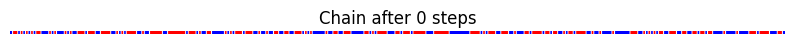

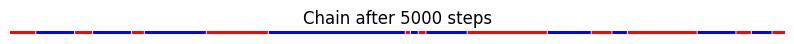

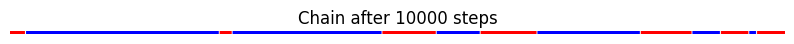

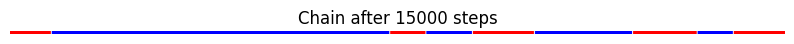

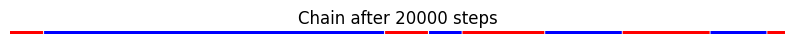

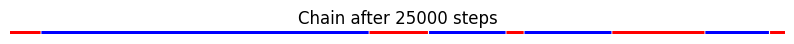

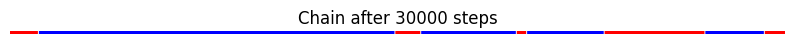

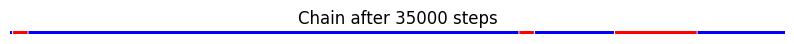

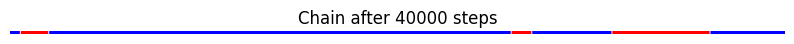

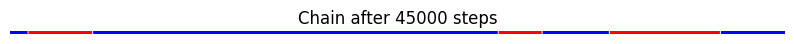

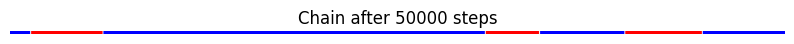

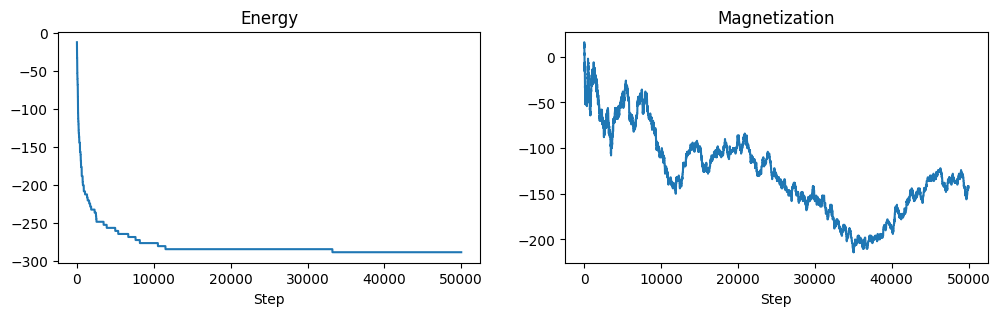

In [46]:
NUM_STEPS = 50000

model_d = IsingModel(
  n_particles = 300,
  coupling_constant = -1,
  external_field = 0,
  beta = 100000
)
model_d.show_chain()
model_d.run_algorithm(NUM_STEPS, 5000)
model_d.plot_energy_and_magnetization()

### 4e. No external field, interactions, higher temperature

$$h = 0, J = -1, \beta = 1.$$

The spins should end up forming domains of spin-ups and spin_downs. The number of domains should be higher than in the previous subsection

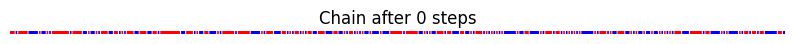

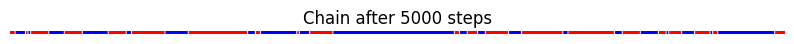

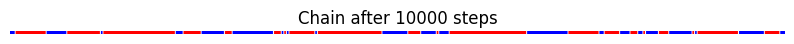

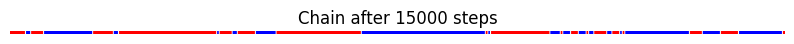

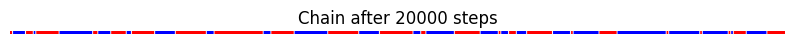

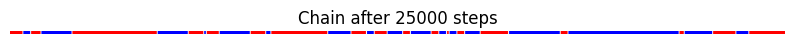

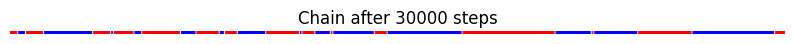

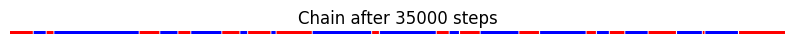

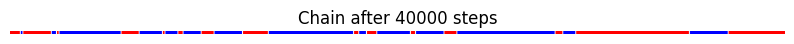

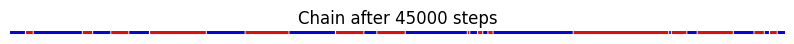

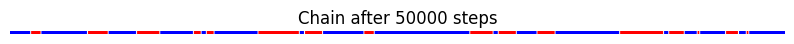

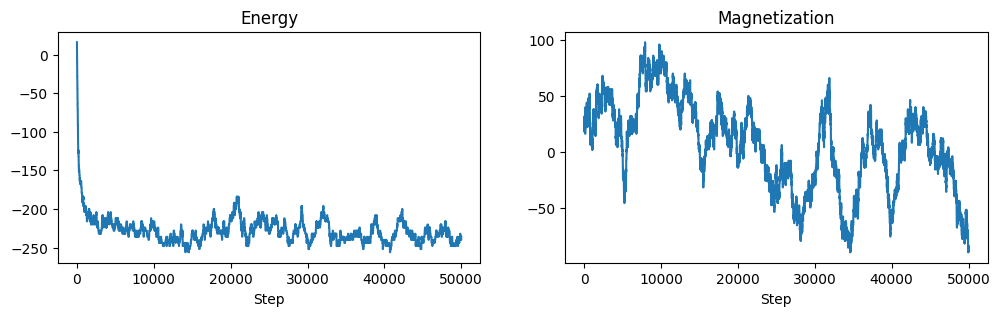

In [50]:
NUM_STEPS = 50000

model_d = IsingModel(
  n_particles = 300,
  coupling_constant = -1,
  external_field = 0,
  beta = 1
)
model_d.show_chain()
model_d.run_algorithm(NUM_STEPS, 5000)
model_d.plot_energy_and_magnetization()

### 4f. External field, interactions, higher temperature

$$h = 0.05, J = -1, \beta = 1.$$

The spins should end up forming domains of spin-ups and spin_downs, but one of the domains is prefered.

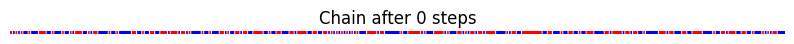

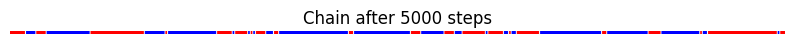

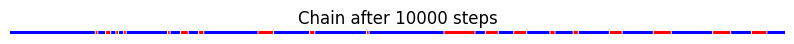

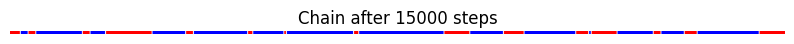

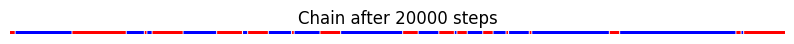

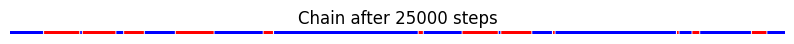

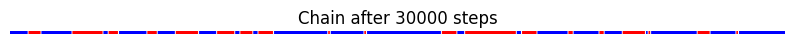

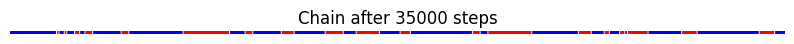

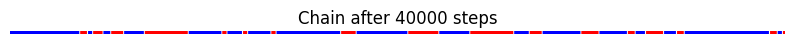

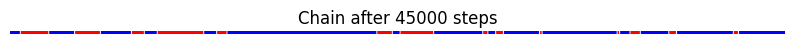

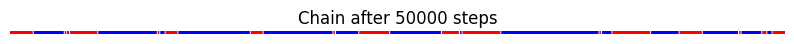

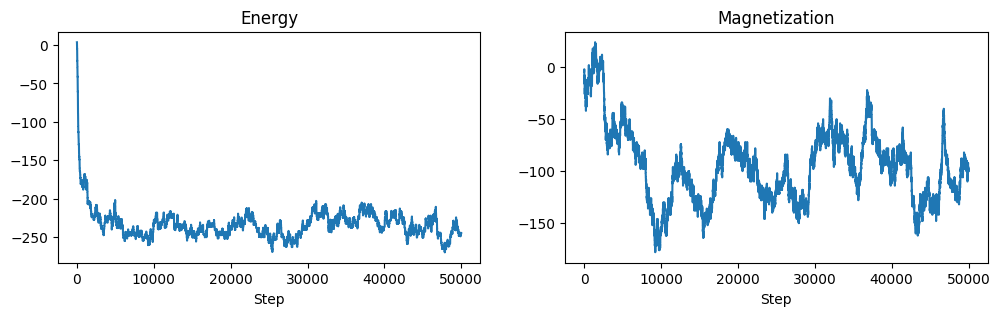

In [57]:
NUM_STEPS = 50000

model_d = IsingModel(
  n_particles = 300,
  coupling_constant = -1,
  external_field = 0.05,
  beta = 1
)
model_d.show_chain()
model_d.run_algorithm(NUM_STEPS, 5000)
model_d.plot_energy_and_magnetization()